In [1]:
include("./PeriodicKdV.jl")
using .PeriodicKdV
using LinearAlgebra, Plots, SparseArrays, Printf
using DifferentialEquations, SpecialFunctions, Elliptic, ApproxFun

In [2]:
function T(λ,Q0,tspan)
    D = Derivative()
    B = Evaluation(tspan[1])
    A = [B               0;
         B*D             0;
         0               B;
         0               B*D;
         -D^2-(Q0+λ)*I   0;
         -I              -D^2-(Q0+λ)*I];
    u,udλ = A\[1;0;0;0;0;0]
    v,vdλ = A\[0;1;0;0;0;0]
    return [u(tspan[2]) v(tspan[2]);
    u'(tspan[2]) v'(tspan[2]);
    udλ(tspan[2]) vdλ(tspan[2]);
    udλ'(tspan[2]) vdλ'(tspan[2])]
end

function Δ(λ,Q0,tspan)
    Ts = T(λ,Q0,tspan)
   (Ts[1,1] + Ts[2,2])/2
end

function Δ2(λ,Q0,tspan)
    Ts = T(λ,Q0,tspan)
   ((Ts[1,1] + Ts[2,2])/2)^2
end

function Δ_newton_step(λ,σ,Q0,tspan)
    Ts = T(λ,Q0,tspan)
    δ = (Ts[1,1] + Ts[2,2] - 2*σ)/(Ts[3,1] + Ts[4,2])
    (λ - δ,δ)
end

function Δ2_newton_step(λ,Q0,tspan)
    Ts = T(λ,Q0,tspan)
    Δ = (Ts[1,1] + Ts[2,2])/2
    dΔ = (Ts[3,1] + Ts[4,2])/2
    δ = (Δ^2 - 1)/(2*Δ*dΔ)
    (λ - δ,δ)
end

function Δroot(λ,σ,Q0,tspan)
    λ0 = λ
    for i = 1:100
        (λ0,δ) = Δ_newton_step(λ0,σ,Q0,tspan)
        if abs(δ) < 1e-15
            break
        end
        if i == 100
            @warn "Max iter"
        end
    end
    λ0
end

function Δ2root(λ,Q0,tspan)
    λ0 = λ
    δ = 0.0
    for i = 1:200
        (λ0,δ) = Δ2_newton_step(λ0,Q0,tspan)
        if abs(δ) < 1e-14
            break
        end
        if i == 100
            @warn "Max iter"
        end
    end
    (λ0,δ)
end

function T12(λ,Q0,tspan)
    Ts = T(λ,Q0,tspan)
    Ts[1,2]
end

function T12_newton_step(λ,Q0,tspan)
    Ts = T(λ,Q0,tspan)
    δ = Ts[1,2]/Ts[3,2]
    (λ - δ,δ)
end

function T12root(λ,Q0,tspan)
    λ0 = λ
    δ = 0.0
    for i = 1:100
        (λ0,δ) = T12_newton_step(λ0,Q0,tspan)
        if abs(δ) < 1e-14
            break
        end
        if i == 100
            @warn "Max iter"
        end
    end
    (λ0,δ)
end

function find_sheet(λ,Q0,tspan)
    TT = T(λ+1im*1e-4,Q0,tspan)
    dd = (TT[1,1] + TT[2,2])/2
    #return -sign(imag(dd^2))
    #println(imag(dd^2) |> sign)
    s1 = -sqrt(dd^2 -1 |> complex) + 1/2*(TT[2,2]-TT[1,1]) |> abs
    s2 =  sqrt(dd^2 -1 |> complex) + 1/2*(TT[2,2]-TT[1,1]) |> abs
    if s1 > s2
        σ = -1.0
    else
        σ = 1.0
    end
    return σ
end

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 20)

In [501]:
q0 = x -> 4*cos(x-.2)
tspan = (0.0,2*pi)
Q0 = Fun(q0,tspan[1]..tspan[2])
Q0per = Fun(q0,ApproxFun.PeriodicSegment(tspan...))
D = Derivative()
B = Evaluation(tspan[1])

ConcreteEvaluation : ApproxFunBase.UnsetSpace() → ConstantSpace


In [502]:
k = 12;

In [513]:
sp = Q0.space
BC = Dirichlet(sp)
D = Derivative()
L = -D^2 - Q0
λDir, v = ApproxFun.eigs(BC,L,500);
λDir = λDir |> sort
σs = map(y -> find_sheet(y,Q0,tspan), λDir[1:k]);
σs = σs.*[(-1)^(j+1) for j in 1:k]

12-element Array{Float64,1}:
  1.0
 -1.0
  1.0
 -1.0
  1.0
 -1.0
  1.0
 -1.0
  1.0
 -1.0
  1.0
 -1.0

In [514]:
d = ApproxFun.PeriodicSegment(tspan[1],2*tspan[2]) # supposes tspan[1] = 0
Q0per = Fun(q0,d)
D = Derivative(Q0per.space)
L = -D^2 - Q0per
λPer, v = ApproxFun.eigs(L,500);
λPer = λPer |> sort;

In [515]:
α1 = λPer[1]
α = λPer[3:2:2k+1] .- α1
β = λPer[2:2:2k] .- α1
gaps = hcat(β,α)
zs = hcat(λDir[1:k] .- α1, σs)
gaps |> display
zs |> display

12×2 Array{Float64,2}:
  0.000340274   2.5427
  2.55434       4.68049
  4.82916       6.19715
  6.94731       7.46486
  9.20693       9.29612
 11.881        11.889
 15.0698       15.0703
 18.7794       18.7794
 23.002        23.002
 27.7327       27.7327
 32.9684       32.9684
 38.7077       38.7077

12×2 Array{Float64,2}:
  1.96593   1.0
  3.19677  -1.0
  5.90458   1.0
  7.16225  -1.0
  9.26491   1.0
 11.8845   -1.0
 15.07      1.0
 18.7794   -1.0
 23.002     1.0
 27.7327   -1.0
 32.9684    1.0
 38.7077   -1.0

In [516]:
gap_test = map( (x,y,z) ->  x <= y <= z, gaps[:,1], zs[:,1], gaps[:,2])  # should be all 1's
for i = 1:length(gap_test)
    if gap_test[i] == 0
        @warn "Zero not in gap.  Error estimate: "*string(min(abs(zs[i,1]-gaps[i,2]),abs(zs[i,1]-gaps[i,1])))
        if zs[i,1] > gaps[i,2]
            zs[i,1] = gaps[i,2]
        else
            zs[i,1] = gaps[i,1]
        end
    end
end

In [517]:
S = HyperellipticSurface(gaps,zs,200);

In [523]:
BA = BakerAkhiezerFunction(S,30,1e-6);

Effective rank of Cauchy operator = 1550
Maximum rank of Cauchy operator = 17280


In [524]:
q(x,t) = KdV(BA, x+6*α1*t, t) - α1

q (generic function with 1 method)

In [525]:
x = tspan[1]:0.5:2*tspan[2] |> Array
Q = map(x -> q(x,0.0) |> real, x);

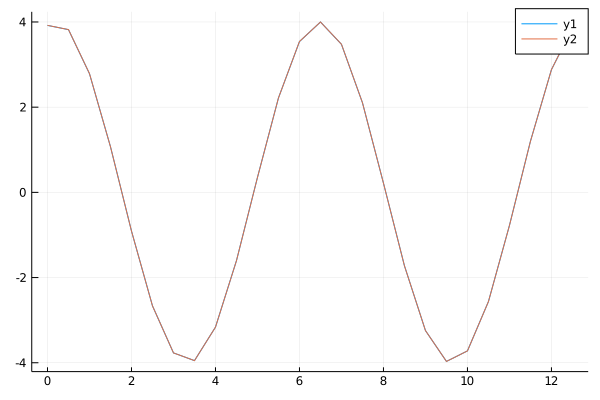

In [526]:
plot(x,Q)
plot!(x, map(q0,x))

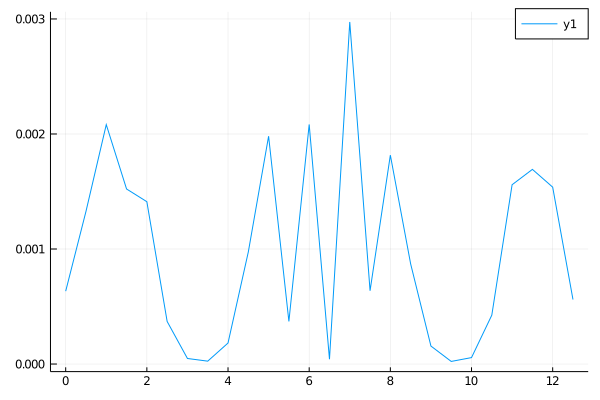

In [527]:
plot(x, abs.(map(q0,x)-Q))

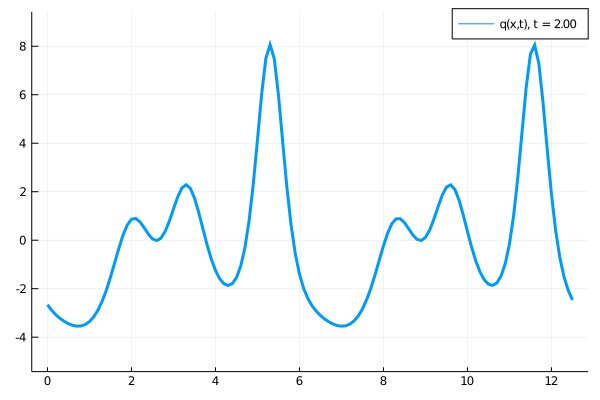

┌ Info: Saved animation to 
│   fn = /Users/thomastrogdon/Dropbox (uwamath)/Projects/Collaborations/Periodic KdV/PeriodicKdV/test2.gif
└ @ Plots /Users/thomastrogdon/.julia/packages/Plots/jpF9l/src/animation.jl:104


Plots.AnimatedGif("/Users/thomastrogdon/Dropbox (uwamath)/Projects/Collaborations/Periodic KdV/PeriodicKdV/test2.gif")
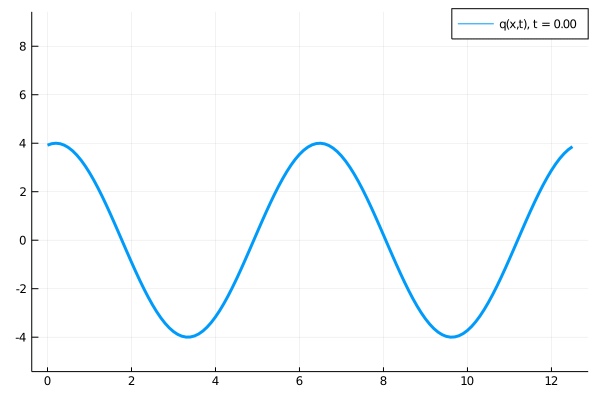

In [532]:
Tend = 2
k = 0.01
n = convert(Int64,ceil(Tend/k))
plot()
anim = Animation()
t = 0.0
x = tspan[1]:0.1:2*tspan[2] |> Array
Q = map(x -> q(x,t) |> real, x);
p = plot(x, Q, xaxis = [minimum(x),maximum(x)], yaxis = [-5,9],lw=3,label = @sprintf("q(x,t), t = %1.2f",t))
frame(anim)
p |> IJulia.display
for i = 2:n+1
    t += k
    IJulia.clear_output(true)
    Q = map(x -> q(x,t) |> real, x);
    p = plot(x, Q, xaxis = [minimum(x),maximum(x)], yaxis = [-5,9],lw=3,label = @sprintf("q(x,t), t = %1.2f",t))
    frame(anim)
    p |> IJulia.display
end
gif(anim,"test2.gif")

┌ Info: Saved animation to 
│   fn = /Users/thomastrogdon/Dropbox (uwamath)/Projects/Collaborations/Periodic KdV/PeriodicKdV/test2.gif
└ @ Plots /Users/thomastrogdon/.julia/packages/Plots/jpF9l/src/animation.jl:104


Plots.AnimatedGif("/Users/thomastrogdon/Dropbox (uwamath)/Projects/Collaborations/Periodic KdV/PeriodicKdV/test2.gif")
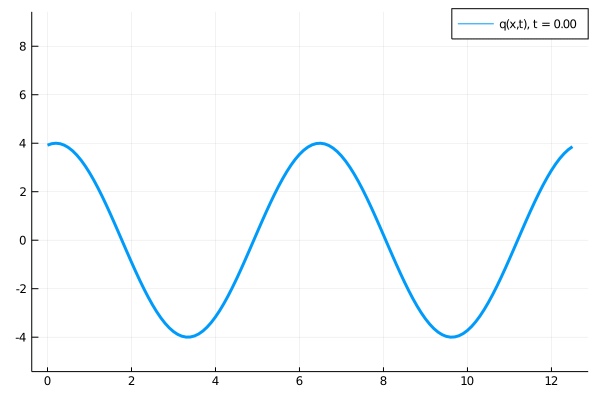

In [534]:
gif(anim,"test2.gif", fps = 5)

In [218]:
x = -1:.01:4
Ts = map( x -> T(x),x);
mtr = T -> (T[1,1] + T[2,2])/2.0
t12 = T -> T[1,2]

MethodError: MethodError: no method matching T(::Float64)
Closest candidates are:
  T(::Any, !Matched::Any, !Matched::Any) at In[170]:2

In [ ]:
p = plot(x,map(mtr,Ts).^2, label = "Δ^2")
plot!(x,map(t12,Ts), xaxis = [-1,maximum(x)], yaxis = [-.1,1.1], label = "T12");
scatter!(λDir,0*λDir, label = "Dirichlet spectrum")
scatter!(λPer,0*λPer .+ 1, label = "Periodic/Antiperiodic spectrum", legend=:outerbottomleft, size = (900,400))

In [ ]:
p |> display

In [ ]:
αβ = [Δ2root(-.5)[1];
Δ2root(1.0)[1];
Δ2root(1.5)[1];
Δ2root(2.3)[1]; 
Δ2root(2.4)[1];
Δ2root(3.9)[1]; 
Δ2root(4.1)[1];
Δ2root(6.1)[1]; 
Δ2root(6.5)[1];
Δ2root(8.2)[1]; 
Δ2root(9.0)[1];
Δ2root(12.0)[1];
Δ2root(12.5)[1];]

In [ ]:
default_Periodic(sp::ApproxFun.Space,k) = PeriodicWrapper(ApproxFun.periodic(domain(sp),k) |> Operator,k)

convert(::Type{Operator{T}},B::PeriodicWrapper) where {T} =
    PeriodicWrapper(Operator{T}(B.op),B.order)::Operator{T}

In [ ]:
abstract type Periodic{S,T} <: ApproxFun.Operator{T} end

struct ConcretePeriodic{S,V,T} <: Periodic{S,T}
    domainspace::S
    rangespace::V
    order::Int
end

struct PeriodicWrapper{S,T} <: Periodic{S,T}
    op::S
    order::Int
end

@ApproxFun.wrapper PeriodicWrapper

PeriodicWrapper(B::Operator,λ=0) = PeriodicWrapper{typeof(B),eltype(B)}(B,λ)

In [ ]:
α = αβ[1:2:end]
β = αβ[2:2:end]
z = [T12root((α[1+i] + β[i])/2)[1] for i = 1:length(β)]
σs = map(find_sheet,z)
gaps = hcat(β,α[2:end])
zs = hcat(z,σs)
α[2:end] - z |> display
z - β |> display

In [ ]:
S = HyperellipticSurface(gaps,zs)

In [ ]:
BA = BakerAkhiezerFunction(S,20,1e-14);

In [ ]:
x = 2:.01:3
Ts = map( x -> T(x),x);
mtr = T -> (T[1,1] + T[2,2])/2.0
t12 = T -> T[1,2]
p = plot(x,map(mtr,Ts).^2 .- 1, yaxis = [-.1,.1], label = "Δ^2-1")
plot!(x,map(t12,Ts), yaxis = [-.1,.1])

In [ ]:
Δ2root(2.3) |> display
Δ2root(2.4) |> display